# Galaxy Classification with Vision Transformer (Pytorch)

Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge



References:

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/

6. https://github.com/joshualin24/vit-pytorch/blob/main/examples/galaxy_classification.ipynb



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-df4db386-e5c3-274d-f12a-4cd16587b7ec)


## Install Vision Transformer (ViT)

In [2]:
! pip -q install vit_pytorch linformer

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from linformer import Linformer
from vit_pytorch.efficient import ViT

cuda:0


## Unzip images

Before running the code, please upload `images_train.zip`, `images_valid.zip` and `images_test.zip` to the workspace.

We upzip these 3 files, and place:

- all training images (n=39,410) into the folder `images_train`
- all validation images (n=9,852) into the folder `images_valid`, and
- all test images (n=12,316) into the folder `images_test`.

We create the folders first if they don't exist.

In [4]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

#### Unzip from Google Drive

In [5]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

#### Unzip from Google Colab workspace

In [ ]:
## Unzip training, validation, and test images
unzipping('images_train.zip', 'images_train')
unzipping('images_valid.zip', 'images_valid')
unzipping('images_test.zip', 'images_test')

## Custom Datasets

In [6]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label

## Custom Transforms

In [8]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor()])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor()])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor()])

    
    return train_transform, valid_transform, test_transform

## Training Function

In [9]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            pred_logits = model(images)
            loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu')

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(images)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu')

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))

    # return the best model
    return model, history_dic

## Tuning Vision Transformer

In [10]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


*******[ gz2_vit ]*******
patch_size = 28
depth = 12
hidden_dim = 128
k_dim = 64
num_heads = 8
batch_size = 64
lr = 0.0003
step_size = 5
gamma = 0.9
max_epoch = 200
Number of trainable parameters: 2785416
Epoch 1/200	Train loss: 1.1671	Train acc: 0.5569	Valid loss: 0.9783	Valid acc: 0.6355	Time: 10m 50s	<--
Epoch 2/200	Train loss: 0.9259	Train acc: 0.6553	Valid loss: 0.8611	Valid acc: 0.6804	Time: 10m 20s	<--
Epoch 3/200	Train loss: 0.8485	Train acc: 0.6874	Valid loss: 0.7950	Valid acc: 0.7082	Time: 10m 16s	<--
Epoch 4/200	Train loss: 0.8037	Train acc: 0.7037	Valid loss: 0.7720	Valid acc: 0.7160	Time: 10m 17s	<--
Epoch 5/200	Train loss: 0.7778	Train acc: 0.7149	Valid loss: 0.7499	Valid acc: 0.7233	Time: 10m 17s	<--
Epoch 6/200	Train loss: 0.7522	Train acc: 0.7238	Valid loss: 0.7452	Valid acc: 0.7246	Time: 10m 18s	<--
Epoch 7/200	Train loss: 0.7348	Train acc: 0.7296	Valid loss: 0.7422	Valid acc: 0.7278	Time: 10m 16s	<--
Epoch 8/200	Train loss: 0.7233	Train acc: 0.7338	Valid loss: 0.7149

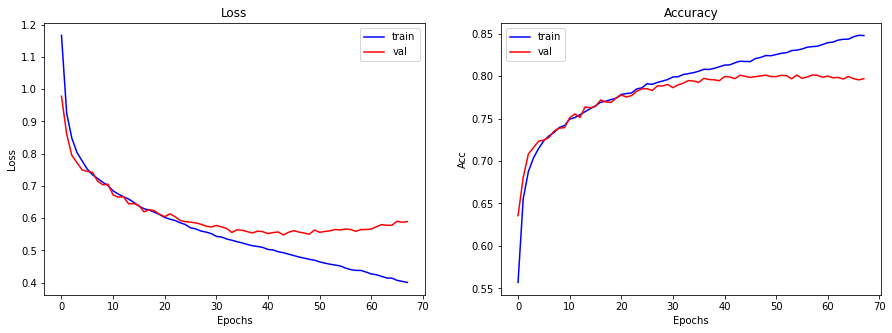

Test loss: 0.5580
Test accuracy: 0.8023


In [11]:
"""
Control parameters
"""
PATCH_SIZE = 28
DEPTH = 12
HIDDEN_DIM = 128
K_DIM = 64
NUM_HEADS = 8

LR = 3e-4
STEP_SIZE = 5
GAMMA = 0.9
MAX_EPOCH = 200


## file name
file_name_to_save = "gz2_vit"

"""
Print out parameters
"""
print("*******[ " + file_name_to_save + " ]*******")
print("===============================")
print("patch_size = {}".format(PATCH_SIZE))
print("depth = {}".format(DEPTH))
print("hidden_dim = {}".format(HIDDEN_DIM))
print("k_dim = {}".format(K_DIM))
print("num_heads = {}".format(NUM_HEADS))
print("batch_size = {}".format(BATCH_SIZE))
print("lr = {}".format(LR))
print("step_size = {}".format(STEP_SIZE))
print("gamma = {}".format(GAMMA))
print("max_epoch = {}".format(MAX_EPOCH))
print("===============================")

"""
Create the ViT Model
"""
# calculate seq_len
seq_len = int((224/PATCH_SIZE)**2) + 1
## Linformer
lin = Linformer(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS, dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=0.1)
## Vision Transformer
model = ViT(image_size=224, patch_size=PATCH_SIZE, num_classes=8, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=3)
# print out number of trainable parameters
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("===============================")

"""
Train
"""
# move to gpu
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
## train and return the best model
model, history_dic = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10)
## Save the best weights
torch.save(model.state_dict(), file_name_to_save+".pth")
## Convert history to dataframe
df = pd.DataFrame(history_dic)
## Save the history
df.to_csv(file_name_to_save + ".csv")
print("files saved as: " + file_name_to_save + ".pth")
print("files saved as: " + file_name_to_save + ".csv")
print("===============================")

"""
Loss and Acc History
"""
# number of epochs
epochs = len(history_dic['valid_acc'])
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# loss plot
ax1.plot(range(epochs), history_dic['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_dic['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
# acc plot
ax2.plot(range(epochs), history_dic['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_dic['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()
plt.show()
print("===============================")

"""
Predict Test Data
"""
# move to gpu
model = model.to(device)
# evaluation
model.eval()
# loss and accuracy
epoch_test_cum_loss = 0.0
epoch_test_cum_corrects = 0
# iterate test data
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.long().to(device)

    with torch.no_grad():
        pred_logits = model(images)
        _, pred_classes = torch.max(pred_logits.detach(), dim=1)
        loss = criterion(pred_logits, labels)

        epoch_test_cum_loss += loss.item() * images.size(0)
        epoch_test_cum_corrects += torch.sum(pred_classes==labels.data)

# calculate final loss and accuracy
test_loss = epoch_test_cum_loss / len(data_test)
test_acc = epoch_test_cum_corrects / len(data_test)

# display
print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.4f}".format(test_acc))
print("===============================")

model.to('cpu')
del model


## 

## Copy files to Google Drive

In [12]:
import shutil

pth_filename = file_name_to_save + ".pth"
csv_filename = file_name_to_save + ".csv"

shutil.copyfile(pth_filename, os.path.join('drive/MyDrive/gz2_datasets', pth_filename))
shutil.copyfile(csv_filename, os.path.join('drive/MyDrive/gz2_datasets', csv_filename))

'drive/MyDrive/gz2_datasets/gz2_vit.csv'